In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd dpm_tensorflow


[Errno 2] No such file or directory: 'dpm_tensorflow'
/content


In [ ]:
cd /content/drive/MyDrive/Major_project_2023-24/dpm_tensorflow


/content/drive/MyDrive/Major_project_2023-24/dpm_tensorflow


In [ ]:
!pip install imagehash


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 5.4 MB/s eta 0:00:00


In [ ]:
from numpy import asarray
import numpy as np

import os
import cv2
import glob
import imagehash
from PIL import Image

import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout
from keras import optimizers
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from pickle import dump

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# b) Load dataset

images = sorted(glob.glob("/content/drive/MyDrive/Major_project_2023-24/dpm_tensorflow/Water Bodies Dataset - Copy/Images/*.jpg"))
masks = sorted(glob.glob("/content/drive/MyDrive/Major_project_2023-24/dpm_tensorflow/Water Bodies Dataset - Copy/Masks/*.jpg"))

print(len(images), len(masks))

1248 1248


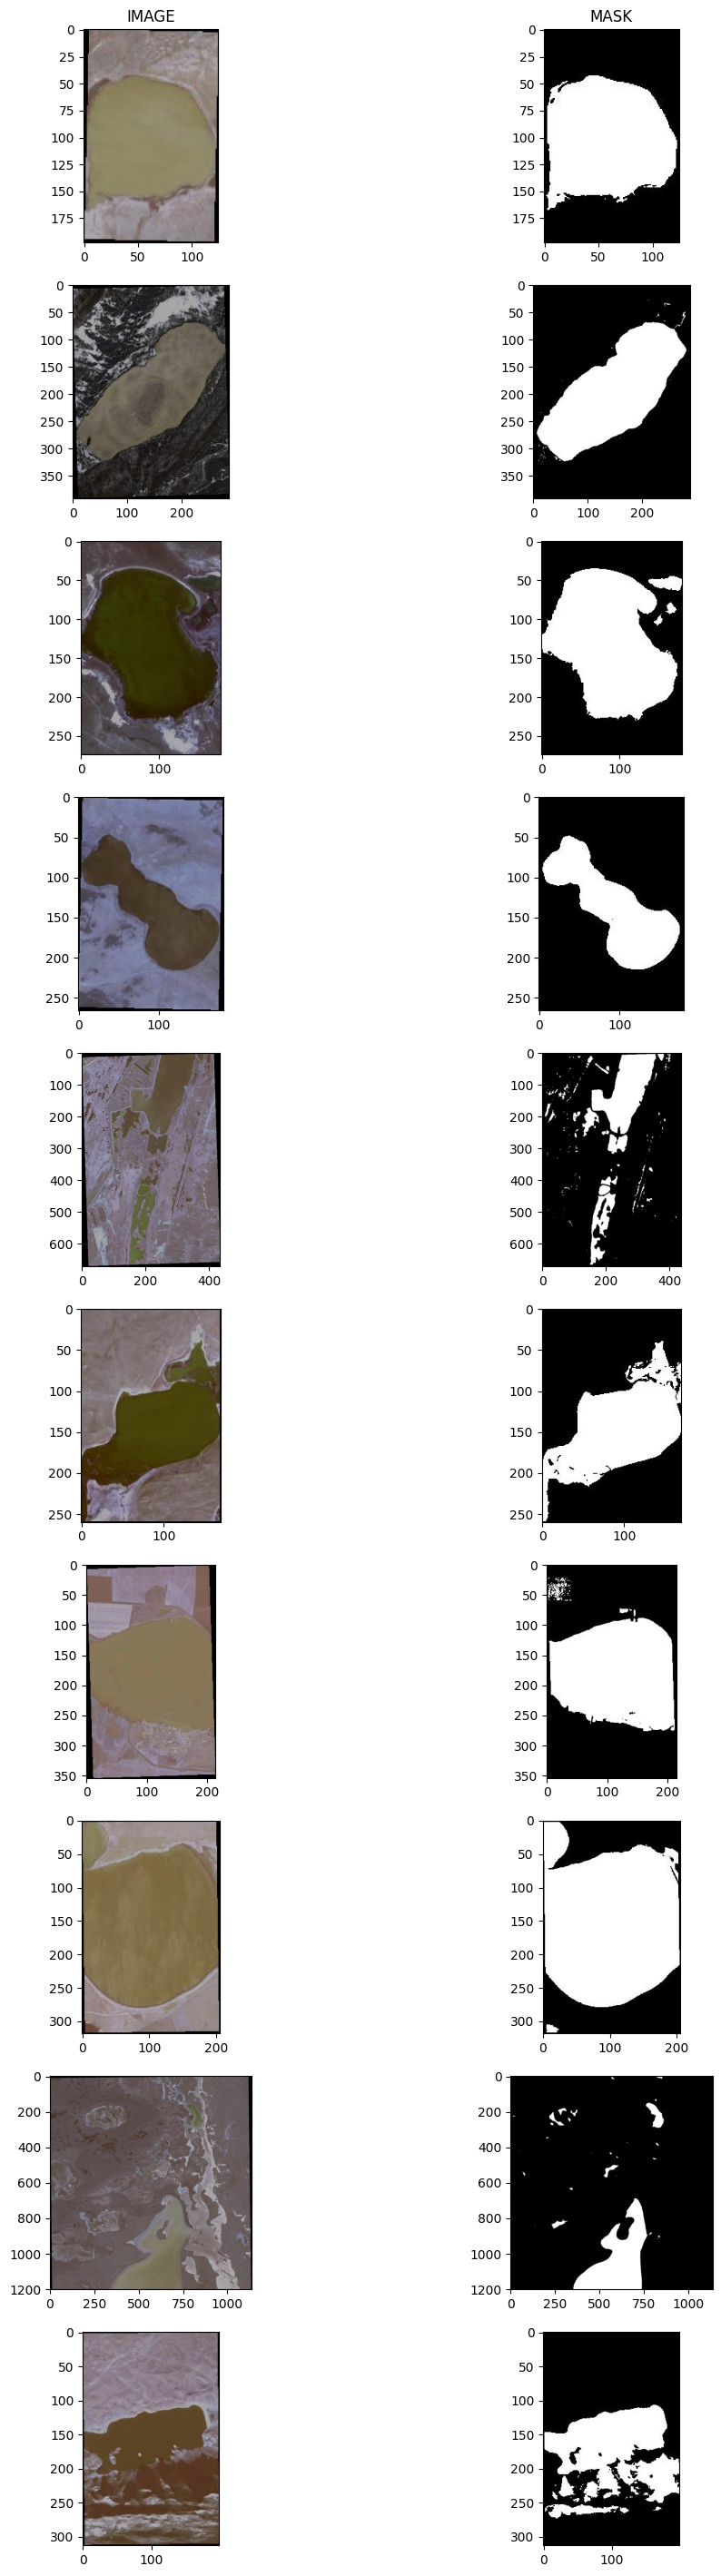

In [ ]:
# a) Image visualization
# plot first few random images in Images and Masks folder
f, axr = plt.subplots(10,2, figsize=(12,36))
for i in range(10):
    idx = np.random.randint(0, len(images))
    original = cv2.imread(images[idx])
    mask = cv2.imread(masks[idx])
    axr[i,0].imshow(original)
    axr[i,1].imshow(mask)
    i +=1
    axr[0, 0].set_title("IMAGE")
    axr[0, 1].set_title("MASK")

In [ ]:
# Calculate statistics of the image dimensions
dimen_img_list = []

for img in images:
    img = cv2.imread(img, cv2.COLOR_BGR2RGB)
    dimen_img = img.shape[:2]
    dimen_img_list.append(dimen_img)

# Convert the list to numpy array
dimen_img_array = np.array(dimen_img_list)

In [ ]:
# Calculate statistics of the image dimensions
print("Statistics of image dimensions:")
print("Minimum width:", np.min(dimen_img_array[:, 1]))
print("Maximum width:", np.max(dimen_img_array[:, 1]))
print("Mean width:", np.mean(dimen_img_array[:, 1]))
print("Median width:", np.median(dimen_img_array[:, 1]))
print("Standard deviation of width:", np.std(dimen_img_array[:, 1]))
print("Minimum height:", np.min(dimen_img_array[:, 0]))
print("Maximum height:", np.max(dimen_img_array[:, 0]))
print("Mean height:", np.mean(dimen_img_array[:, 0]))
print("Median height:", np.median(dimen_img_array[:, 0]))
print("Standard deviation of height:", np.std(dimen_img_array[:, 0]))

Statistics of image dimensions:
Minimum width: 12
Maximum width: 5640
Mean width: 462.3838141025641
Median width: 270.0
Standard deviation of width: 575.1263024279336
Minimum height: 7
Maximum height: 7093
Mean height: 647.7227564102565
Median height: 392.0
Standard deviation of height: 790.1273388495872


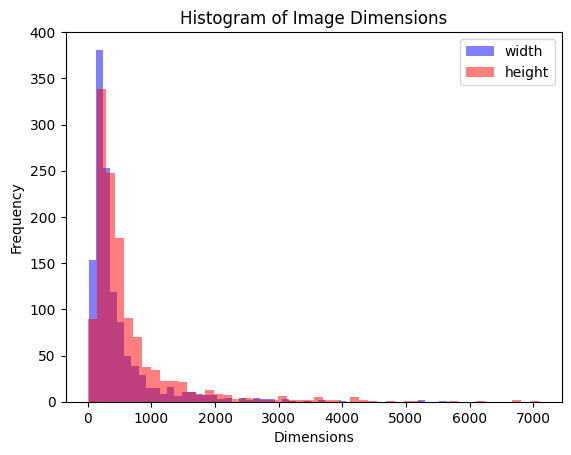

In [ ]:
# Plot the histogram
plt.hist(dimen_img_array[:, 1], bins=50, alpha=0.5, color='blue', label='width')
plt.hist(dimen_img_array[:, 0], bins=50, alpha=0.5, color='red', label='height')
plt.xlabel('Dimensions')
plt.ylabel('Frequency')
plt.title('Histogram of Image Dimensions')
plt.legend()
plt.show()

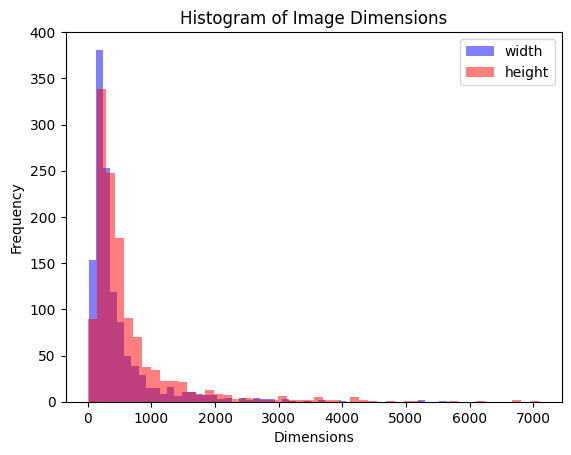

In [ ]:
# Plot the histogram
plt.hist(dimen_img_array[:, 1], bins=50, alpha=0.5, color='blue', label='width')
plt.hist(dimen_img_array[:, 0], bins=50, alpha=0.5, color='red', label='height')
plt.xlabel('Dimensions')
plt.ylabel('Frequency')
plt.title('Histogram of Image Dimensions')
plt.legend()
plt.show()

In [ ]:
# a) Data Cleaning

#Detect and remove duplicate images and masks
hashes = {}
to_remove = []

for file in images:
    if file.endswith('.jpg'):
        with open(file, 'rb') as f:
            img = Image.open(f)
            # Compute the hash value for the image
            h = imagehash.phash(img)
            # Check if the hash value already exists in the dictionary
            if h in hashes:
                print(f'Duplicate image found: {file} and {hashes[h]}')
                to_remove.append(file)
                mask_file = os.path.join("/content/drive/MyDrive/Major_project_2023-24/dpm_tensorflow/Water Bodies Dataset - Copy/Masks", os.path.basename(file))
                to_remove.append(mask_file)
            else:
                hashes[h] = file

Duplicate image found: /content/drive/MyDrive/Major_project_2023-24/dpm_tensorflow/Water Bodies Dataset - Copy/Images/water_body_1244.jpg and /content/drive/MyDrive/Major_project_2023-24/dpm_tensorflow/Water Bodies Dataset - Copy/Images/water_body_1023.jpg
Duplicate image found: /content/drive/MyDrive/Major_project_2023-24/dpm_tensorflow/Water Bodies Dataset - Copy/Images/water_body_1333.jpg and /content/drive/MyDrive/Major_project_2023-24/dpm_tensorflow/Water Bodies Dataset - Copy/Images/water_body_1023.jpg
Duplicate image found: /content/drive/MyDrive/Major_project_2023-24/dpm_tensorflow/Water Bodies Dataset - Copy/Images/water_body_1552.jpg and /content/drive/MyDrive/Major_project_2023-24/dpm_tensorflow/Water Bodies Dataset - Copy/Images/water_body_1023.jpg
Duplicate image found: /content/drive/MyDrive/Major_project_2023-24/dpm_tensorflow/Water Bodies Dataset - Copy/Images/water_body_1619.jpg and /content/drive/MyDrive/Major_project_2023-24/dpm_tensorflow/Water Bodies Dataset - Copy

In [ ]:
# Create a new list of filenames that excludes the duplicates
new_images = [file for file in images if file not in to_remove]
new_masks = [os.path.join("/content/drive/MyDrive/Major_project_2023-24/dpm_tensorflow/Water Bodies Dataset - Copy/Masks", os.path.basename(file)) for file in new_images]
print(len(new_images), len(new_masks))

1238 1238


In [ ]:
# Load, filter blank and abnormal size images and masks, and resize them to the median values or larger

min_size = 32
df_images = []
df_masks = []

height = width = 300

for image, mask in zip(new_images, new_masks):
    #cv2.imread reads image in BGR, we need to convert it back to the standard mode RGB
    n = cv2.imread(image, cv2.COLOR_BGR2RGB)
    m = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)

    # Check if the image has size > min_size and is entirely black or white
    if min(n.shape[:2]) > min_size and ((m != 0).any() and (m != 255).any()):
        n = cv2.resize(n, (height, width)) # resize to median values or larger
        df_images.append(n)
        m = cv2.resize(m, (height, width)) # resize to median values or larger
        df_masks.append(m)

# Convert image into array of pixels
df_images = asarray(df_images)

# Convert mask into array of pixels
df_masks = asarray(df_masks)

print(len(df_images), len(df_masks))

1163 1163


In [ ]:
# b) Split data into train and test sets

X = df_images
y = df_masks

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=1)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.015, random_state=1)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape)

(872, 300, 300, 3) (872, 300, 300) (286, 300, 300, 3) (286, 300, 300) (5, 300, 300, 3) (5, 300, 300)


In [ ]:
# Flatten images and convert data from numpy array to float type
X_train = X_train.reshape(X_train.shape[0], height, width, 3).astype('float32')
X_test = X_test.reshape(X_test.shape[0], height, width, 3).astype('float32')
X_val = X_val.reshape(X_val.shape[0], height, width, 3).astype('float32')
y_train = y_train.reshape(y_train.shape[0], height, width).astype('float32')
y_test = y_test.reshape(y_test.shape[0], height, width).astype('float32')
y_val = y_val.reshape(y_val.shape[0], height, width).astype('float32')

In [ ]:
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255
X_val = X_val / 255
y_train = y_train / 255
y_test = y_test / 255
y_val = y_val / 255

In [ ]:
input_shape = (height, width, 3)

def base_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoding layers
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Decoding layers
    up3 = layers.UpSampling2D(size=(2, 2))(pool2)
    conv3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up3)
    conv4 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv3)
    up5 = layers.UpSampling2D(size=(2, 2))(conv4)
    outputs = layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(up5)

    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Build the model
model = base_model(input_shape)

# Reshape target data to match output shape of the model
y_train = y_train.reshape(-1, height, width, 1)
y_test = y_test.reshape(-1, height, width, 1)

In [ ]:
print(X_train.shape, X_test.shape)

(872, 300, 300, 3) (286, 300, 300, 3)


In [ ]:
# Evaluate accuracy on the test set
accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)

# Make predictions on the test set
predictions = model.predict(X_test)

# You can use predictions as needed for further analysis
# For example, if you want the predicted classes (assuming a classification problem with softmax output):
predicted_classes = np.argmax(predictions, axis=1)

# If you want the raw prediction probabilities:
raw_probabilities = predictions

# If you want to compare the predictions with the actual labels
# (useful for classification problems):
compare_results = np.equal(predicted_classes, np.argmax(y_test, axis=1))

9/9 [==============================] - 8s 306ms/step - loss: 0.6897 - accuracy: 0.5751
Test Accuracy: [0.6897346377372742, 0.57505863904953]
9/9 [==============================] - 1s 59ms/step


In [ ]:
# Define a callback for early stopping if the validation loss does not improve for 10 consecutive
# epochs (patience=10).
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
# Fit the model to train and test sets
history = model.fit(X_train, y_train, batch_size=64, epochs=30, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/30
14/14 [==============================] - 30s 1s/step - loss: 0.6057 - accuracy: 0.5914 - val_loss: 0.5718 - val_accuracy: 0.5880
Epoch 2/30
14/14 [==============================] - 5s 375ms/step - loss: 0.5384 - accuracy: 0.5905 - val_loss: 0.5021 - val_accuracy: 0.5901
Epoch 3/30
14/14 [==============================] - 5s 372ms/step - loss: 0.5058 - accuracy: 0.6714 - val_loss: 0.4898 - val_accuracy: 0.6973
Epoch 4/30
14/14 [==============================] - 5s 373ms/step - loss: 0.4904 - accuracy: 0.6931 - val_loss: 0.4624 - val_accuracy: 0.7106
Epoch 5/30
14/14 [==============================] - 6s 433ms/step - loss: 0.4718 - accuracy: 0.6882 - val_loss: 0.4488 - val_accuracy: 0.7066
Epoch 6/30
14/14 [==============================] - 5s 375ms/step - loss: 0.4445 - accuracy: 0.6960 - val_loss: 0.4296 - val_accuracy: 0.7116
Epoch 7/30
14/14 [==============================] - 5s 372ms/step - loss: 0.4422 - accuracy: 0.7017 - val_loss: 0.4539 - val_accuracy: 0.7058
Epoch 8/

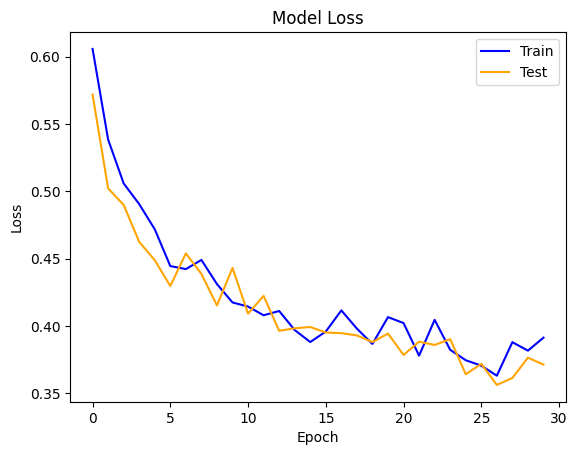

In [ ]:
# Plot diagnostic learning curves
plt.title('Model Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Test"], loc ="upper right")

In [ ]:
# Evaluate accuracy on the test set
accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)

# Make predictions on the test set
predictions = model.predict(X_test)

# You can use predictions as needed for further analysis
# For example, if you want the predicted classes (assuming a classification problem with softmax output):
predicted_classes = np.argmax(predictions, axis=1)

# If you want the raw prediction probabilities:
raw_probabilities = predictions

# If you want to compare the predictions with the actual labels
# (useful for classification problems):
compare_results = np.equal(predicted_classes, np.argmax(y_test, axis=1))

9/9 [==============================] - 1s 70ms/step - loss: 0.3713 - accuracy: 0.7303
Test Accuracy: [0.3712964951992035, 0.7302697896957397]
9/9 [==============================] - 0s 52ms/step


In [ ]:
gen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

In [ ]:
train_gen = gen.flow(X_train, y_train, batch_size=64)
test_gen = gen.flow(X_test, y_test, batch_size=64)

In [ ]:
model2 = base_model(input_shape)

In [ ]:
history2 = model2.fit(train_gen, epochs=30, batch_size=64, validation_data=test_gen, callbacks=[early_stopping])

Epoch 1/30
14/14 [==============================] - 34s 2s/step - loss: 0.6298 - accuracy: 0.5693 - val_loss: 0.6119 - val_accuracy: 0.5880
Epoch 2/30
14/14 [==============================] - 30s 2s/step - loss: 0.5827 - accuracy: 0.5905 - val_loss: 0.5603 - val_accuracy: 0.5934
Epoch 3/30
14/14 [==============================] - 26s 2s/step - loss: 0.5618 - accuracy: 0.6326 - val_loss: 0.5574 - val_accuracy: 0.6368
Epoch 4/30
14/14 [==============================] - 30s 2s/step - loss: 0.5604 - accuracy: 0.6341 - val_loss: 0.5444 - val_accuracy: 0.6558
Epoch 5/30
14/14 [==============================] - 26s 2s/step - loss: 0.5547 - accuracy: 0.6368 - val_loss: 0.5475 - val_accuracy: 0.6445
Epoch 6/30
14/14 [==============================] - 30s 2s/step - loss: 0.5546 - accuracy: 0.6371 - val_loss: 0.5462 - val_accuracy: 0.6481
Epoch 7/30
14/14 [==============================] - 27s 2s/step - loss: 0.5494 - accuracy: 0.6444 - val_loss: 0.5351 - val_accuracy: 0.6599
Epoch 8/30
14/14 [==

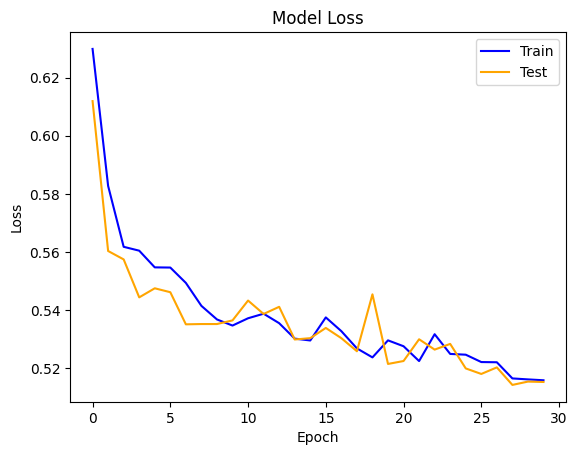

In [ ]:
plt.title('Model Loss')
plt.plot(history2.history['loss'], color='blue', label='train')
plt.plot(history2.history['val_loss'], color='orange', label='test')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Test"], loc ="upper right")

In [ ]:
# Evaluate accuracy on the test set
accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)

# Make predictions on the test set
predictions = model.predict(X_test)

# You can use predictions as needed for further analysis
# For example, if you want the predicted classes (assuming a classification problem with softmax output):
predicted_classes = np.argmax(predictions, axis=1)

# If you want the raw prediction probabilities:
raw_probabilities = predictions

# If you want to compare the predictions with the actual labels
# (useful for classification problems):
compare_results = np.equal(predicted_classes, np.argmax(y_test, axis=1))

9/9 [==============================] - 1s 66ms/step - loss: 0.3713 - accuracy: 0.7303
Test Accuracy: [0.3712964951992035, 0.7302697896957397]
9/9 [==============================] - 0s 51ms/step


1/1 [==============================] - 1s 692ms/step


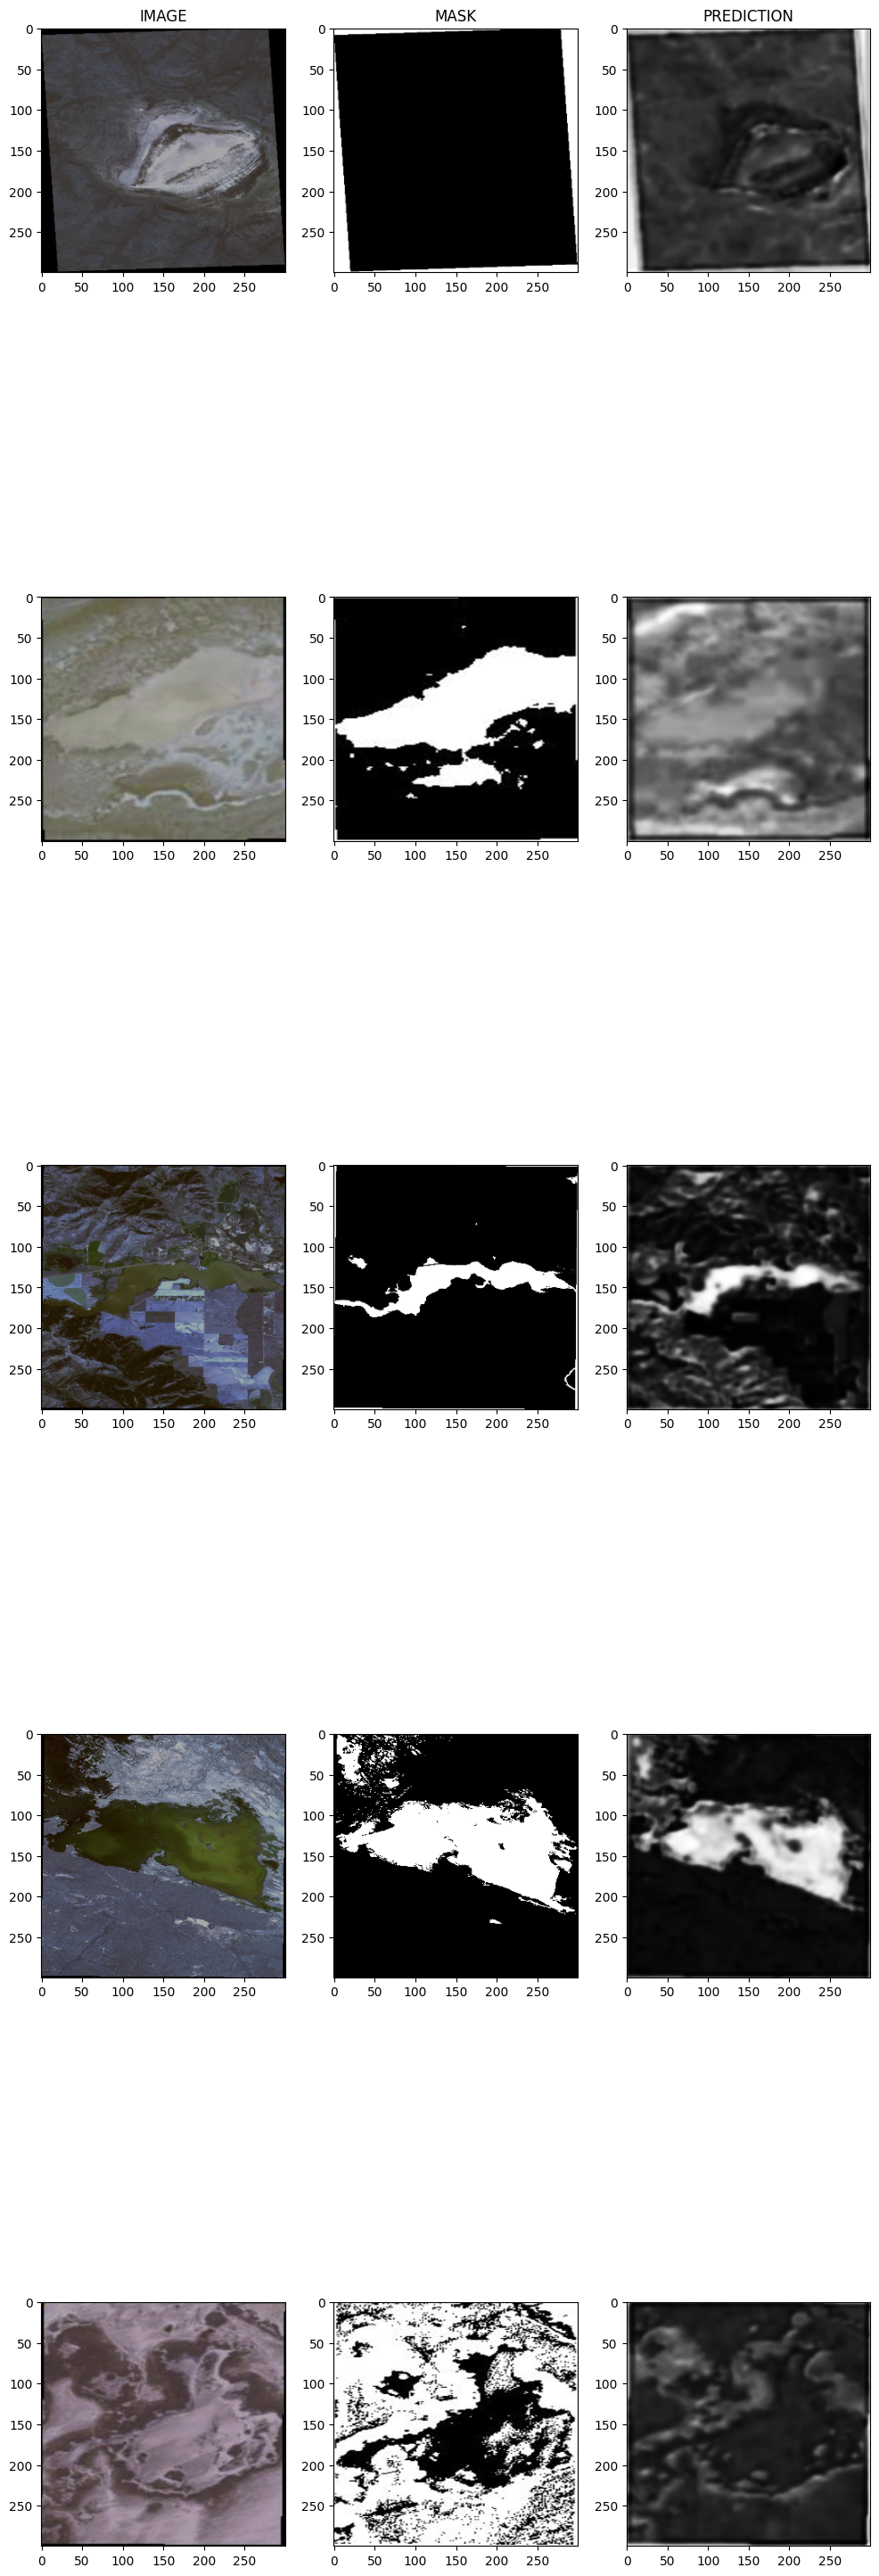

In [ ]:
Pred = model.predict(X_val)

# Plot original and predicted images
fig, ax = plt.subplots(5, 3, figsize=(12,40))
for i in range(5):
    orig = X_val[i]
    msk = y_val[i]
    pred = Pred[i]
    ax[i,0].imshow(orig)
    ax[i,1].imshow(msk, cmap='gray')
    ax[i,2].imshow(pred, cmap='gray')
    i +=1
    ax[0, 0].set_title("IMAGE")
    ax[0, 1].set_title("MASK")
    ax[0, 2].set_title("PREDICTION")

In [ ]:
# b) Save the model for later use

# save the model to disk
filename = 'finalized_model.sav'
dump(model, open(filename, 'wb'))
model.save('/content/drive/MyDrive/Major_project_2023-24/dpm_tensorflow')